In [2]:
import numpy as np # linear algebra
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import os.path
import json

In [3]:
resnet50_path = './working/models/ResNet50_final.h5'
class_indices_path = './working/models/class_indices.npy'
model = load_model(resnet50_path)

class_indices = np.load(class_indices_path, allow_pickle=True).item()

2022-09-09 16:04:13.894535: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
img_width, img_height = 224, 224

# invert the class dictionary in order to get the label for the id
inv_map = {v: k for k, v in class_indices.items()}

predicted_vals = np.array([])
real_vals = np.array([])

for dirname, _, filenames in os.walk('./input/pneumonia-detection/test'):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        image = load_img(image_path, target_size=(img_width, img_height), interpolation='lanczos')
        
        image = img_to_array(image)

        # important! otherwise the predictions will be '0'
        image = image / 255.0

        # add a new axis to make the image array confirm with
        # the (samples, height, width, depth) structure
        image = np.expand_dims(image, axis=0)

        # get the probabilities for the prediction
        probabilities = model.predict(image)

        prediction_probability = probabilities[0, probabilities.argmax(axis=1)][0]

        class_predicted = np.argmax(probabilities, axis=1)

        inID = class_predicted[0]

        label = inv_map[inID]
        
        class_dir = os.path.basename(dirname)

        if np.size(predicted_vals) == 0:
            predicted_vals = [inID]
        else:
            predicted_vals = np.concatenate((predicted_vals, [inID]), axis=0)
            
        real_vals = np.append(real_vals, class_indices[str(class_dir)])

In [5]:
print(predicted_vals.shape)
print(real_vals.shape)

(624,)
(624,)


In [6]:
print("\nClassification report:")
print(classification_report(real_vals, predicted_vals))


Classification report:
              precision    recall  f1-score   support

         0.0       0.92      0.47      0.62       234
         1.0       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.84      0.72      0.74       624
weighted avg       0.82      0.79      0.77       624



In [7]:
print(inv_map)

{0: 'NORMAL', 1: 'PNEUMONIA'}


In [13]:
cm = confusion_matrix(real_vals, predicted_vals,)
print("\nConfusion matrix:")
print("Labels: ", inv_map)
print(cm)


Confusion matrix:
Labels:  [[110 124]
 [  9 381]]
{0: 'NORMAL', 1: 'PNEUMONIA'}


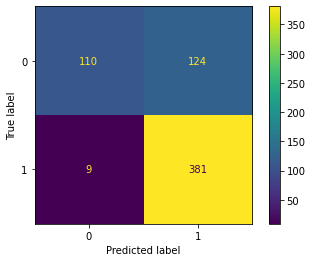

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=inv_map)
disp.plot()
plt.show()